In [0]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.2.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [0]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2020-05-19 17:29:33--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.02s   

2020-05-19 17:29:34 (30.7 MB/s) - ‘spam.csv’ saved [503663/503663]



In [0]:
!head spam.csv

UnicodeDecodeError: ignored

In [0]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [0]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [0]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [0]:
# rename columns to something better
df.columns = ['labels', 'data']

In [0]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [0]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [0]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [29]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7136 unique tokens.


In [30]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [31]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


In [0]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [33]:
# Compile and fit
model.compile( loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])


print('Training model...')
r = model.fit( data_train,
  Ytrain,  epochs=10, validation_data=(data_test, Ytest) )

Training model...
Epoch 1/10
117/117 [==============================] - 9s 78ms/step - loss: 0.4531 - accuracy: 0.8647 - val_loss: 0.3879 - val_accuracy: 0.8684
Epoch 2/10
117/117 [==============================] - 9s 74ms/step - loss: 0.3907 - accuracy: 0.8647 - val_loss: 0.3761 - val_accuracy: 0.8684
Epoch 3/10
117/117 [==============================] - 9s 74ms/step - loss: 0.3563 - accuracy: 0.8647 - val_loss: 0.3086 - val_accuracy: 0.8684
Epoch 4/10
117/117 [==============================] - 9s 76ms/step - loss: 0.2216 - accuracy: 0.8961 - val_loss: 0.1676 - val_accuracy: 0.9744
Epoch 5/10
117/117 [==============================] - 9s 74ms/step - loss: 0.1030 - accuracy: 0.9879 - val_loss: 0.1131 - val_accuracy: 0.9744
Epoch 6/10
117/117 [==============================] - 9s 75ms/step - loss: 0.0615 - accuracy: 0.9914 - val_loss: 0.0977 - val_accuracy: 0.9761
Epoch 7/10
117/117 [==============================] - 9s 76ms/step - loss: 0.0436 - accuracy: 0.9933 - val_loss: 0.0898 - va

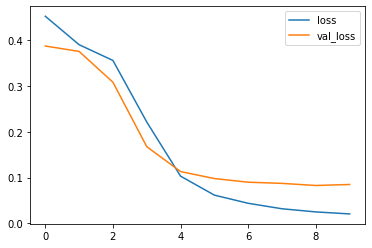

In [34]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

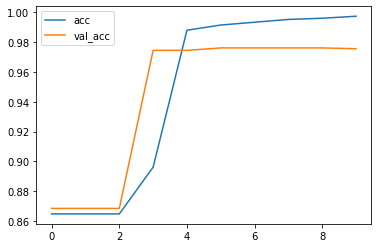

In [35]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [0]:
model.accuracy(y_test, pred)